In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
CLUSTER = "WEBSTER"
LEVELS = [CLUSTER, f"{CLUSTER}_pred", f"{CLUSTER}_true"]

In [3]:
df = pd.read_csv("../predictions/predictions_TGCN_sparkling-leaf-4.csv", index_col=0, parse_dates=["Date"])
# Keep only the columns relataed to the cluster + the date
df = df.loc[:, (df.columns.str.startswith(CLUSTER) | (df.columns == "Date"))]
df.head()

,Date,WEBSTER,WEBSTER_pred,WEBSTER_true
0,2019-01-01 00:30:00,0.0,0.031541,0.0
1,2019-01-01 01:00:00,0.0,0.031546,0.0
2,2019-01-01 01:30:00,0.0,0.031549,0.0
3,2019-01-01 02:00:00,0.0,0.031553,0.0
4,2019-01-01 02:30:00,0.0,0.031556,0.0


<Axes: xlabel='Date'>

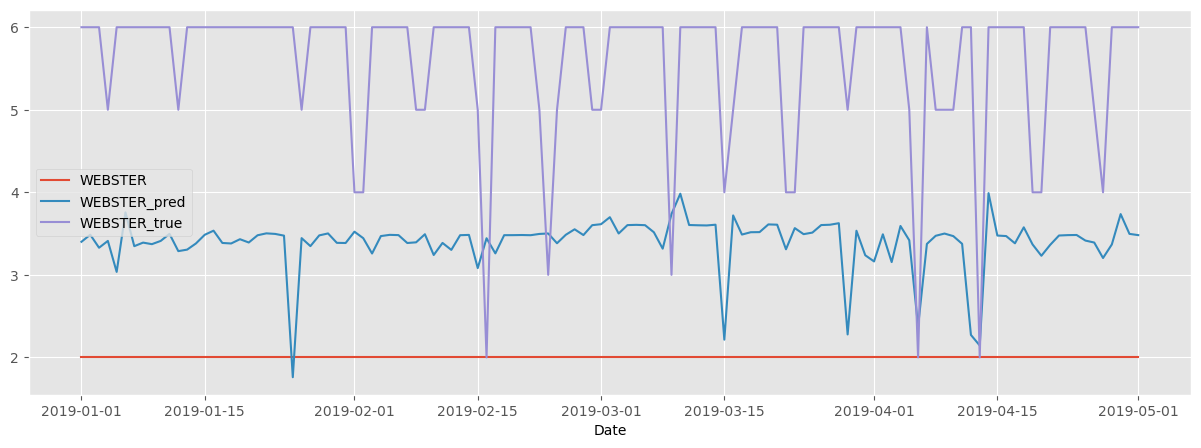

In [4]:
# find the highest predictions for each day
df.groupby(df["Date"].dt.date)[LEVELS].max().plot(figsize=(15, 5))

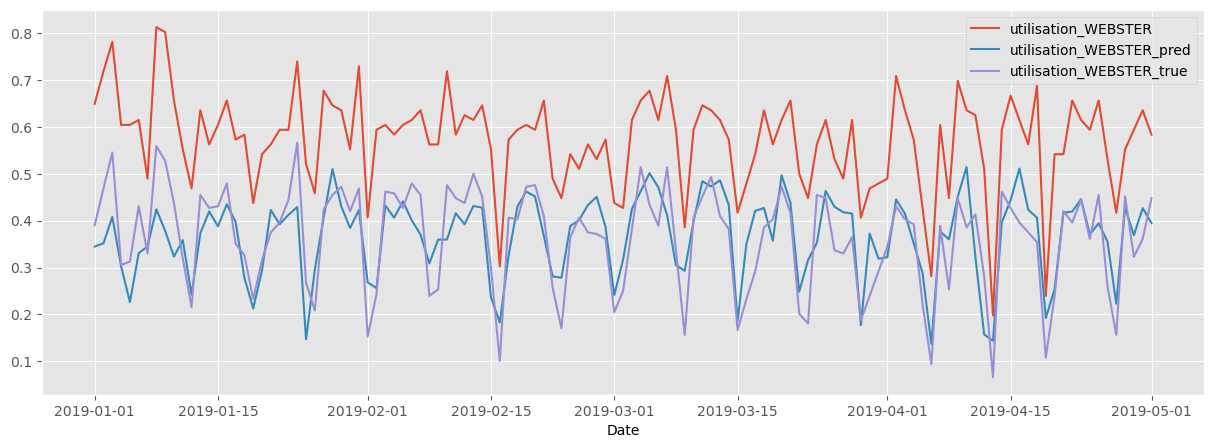

In [5]:

def plot_utilisation_per_day(df):
    df_util_plot = df.copy()
    # We should provide tau from the model training
    for col in LEVELS:
        df_util_plot['tau_'+col] = df_util_plot[col].max()

    sessions_per_day = df_util_plot.groupby(df_util_plot["Date"].dt.date).sum().copy()

    # Calculate utilisation
    for col in LEVELS:
        sessions_per_day['utilisation_'+col] = sessions_per_day[col] / sessions_per_day['tau_'+col]
    # Plot
    # drop all tau columns
    sessions_per_day = sessions_per_day[sessions_per_day.columns[sessions_per_day.columns.str.startswith('utilisation_')]]

    sessions_per_day.plot(figsize=(15, 5))
    sessions_per_day.head()

plot_utilisation_per_day(df)

In [6]:
def calculate_utility(df, CLUSTER, max_tau):
    """ 
    Calulcate the utility for a given cluster, given predictions, censored and true values of usage, for taus from 1 - max_tau.
    """
    util_values = {level: [] for level in [f"{CLUSTER}_pred", f"{CLUSTER}_true", CLUSTER]}
    # calculate the utility for predicted usage, true usage and censored usage, for each tau
    for level, util_list in util_values.items():
        for tau_hypothetical in range(1, max_tau + 1):
            df_util = df.copy()
            # clip the values to the hypothetical tau (we use values from df instead of df_util to avoid clipping the values multiple times)
            df_util[level] = df[level].clip(upper=tau_hypothetical)
            # add the tau_hypothetical as a column
            df_util[f'tau_{tau_hypothetical}'] = tau_hypothetical
            # Sum the half-hourly values to get the daily values
            tmp = df_util.groupby(df_util["Date"].dt.date)[[level, f'tau_{tau_hypothetical}']].sum()
            # calculate the utility per day
            tmp['utilisation'] = (tmp[level] / tmp[f'tau_{tau_hypothetical}'])
            # add the mean utility to the list
            util_list.append(tmp['utilisation'].mean())

    return util_values
utility_values = calculate_utility(df, CLUSTER, 12)

In [7]:
df_utilisation = pd.DataFrame(utility_values)
df_utilisation['Capacity'] = df_utilisation.index + 1
df_utilisation

,WEBSTER_pred,WEBSTER_true,WEBSTER,Capacity
0,0.641776,0.643540,0.643540,1
1,0.533521,0.572340,0.572340,2
2,0.464007,0.514854,0.381560,3
3,0.366601,0.462553,0.286170,4
4,0.293281,0.413919,0.228936,5
5,0.244401,0.363589,0.190780,6
6,0.209486,0.311647,0.163526,7
7,0.183300,0.272692,0.143085,8
8,0.162934,0.242392,0.127187,9
9,0.146640,0.218153,0.114468,10


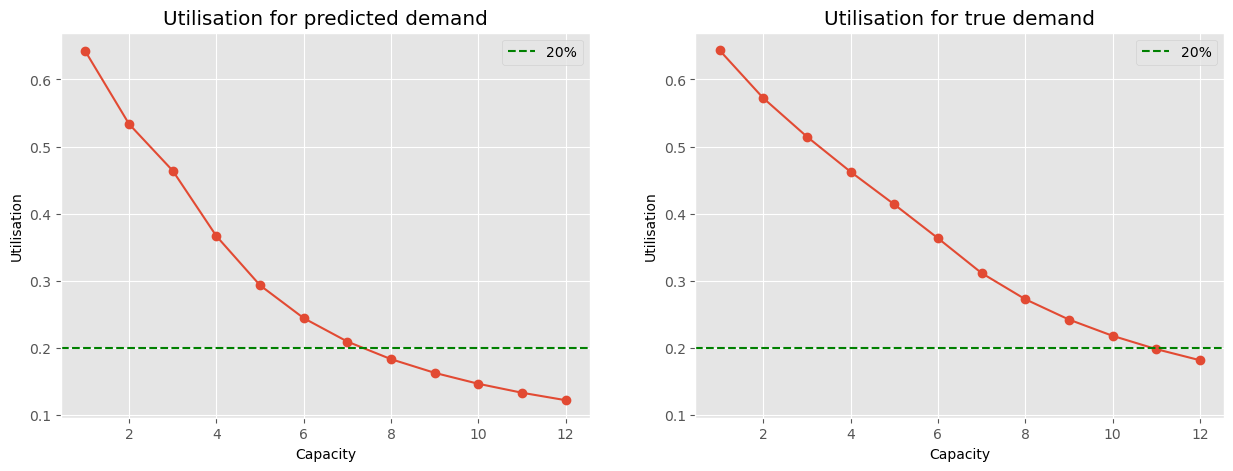

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
axs[0].plot(df_utilisation['Capacity'], df_utilisation[f"{CLUSTER}_pred"], '-o')
axs[0].set_title("Utilisation for predicted demand")

axs[1].plot(df_utilisation['Capacity'], df_utilisation[f"{CLUSTER}_true"], '-o')
axs[1].set_title("Utilisation for true demand")

for ax in axs:
    ax.axhline(y=0.2, linestyle='--', color='g', label="20%")
    ax.set_xlabel("Capacity")
    ax.set_ylabel("Utilisation")
    ax.yaxis.set_tick_params(labelleft=True)
    ax.legend()

plt.show()